# Initialization

In [58]:
import os
dataset_folder_path = '.\godaddy-microbusiness-density-forecasting'
for dirname, _, filenames in os.walk(dataset_folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\godaddy-microbusiness-density-forecasting\census_starter.csv
.\godaddy-microbusiness-density-forecasting\sample_submission.csv
.\godaddy-microbusiness-density-forecasting\test.csv
.\godaddy-microbusiness-density-forecasting\train.csv


In [59]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

In [114]:
from xgboost import XGBRegressor # GBDT Library, XGBosst Regressor
# Load Sklearn libraries...
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor # Regressors

from sklearn.metrics import mean_squared_error, r2_score, make_scorer # Load metrics
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, GroupKFold, KFold # Load CV strategies
from sklearn.preprocessing import LabelEncoder # Load encoder packages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder # Load Normalization libraries
from sklearn.pipeline import Pipeline # Load sklearn pipelines, in case are needed in the CV loop
from sklearn.compose import ColumnTransformer # Load
import pandas as pd
import numpy as np
import optuna
import traceback
import xgboost
from sklearn.model_selection import  cross_validate
import matplotlib.pyplot as plt # Visualization libraries

# Configuration

In [61]:
DATA_ROWS = None
# Dataframe, the amount of rows and cols to visualize...
NROWS = 50
NCOLS = 15
# Main data location path...
BASE_PATH = '...'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', NCOLS)
pd.set_option('display.max_rows', NROWS)

# Load Dataset

In [62]:
input_path = Path('./')

train_df = pd.read_csv(os.path.join(dataset_folder_path,'train.csv'))
census_df = pd.read_csv(os.path.join(dataset_folder_path,'census_starter.csv'))
test_df = pd.read_csv(os.path.join(dataset_folder_path,'test.csv'))
submission = pd.read_csv(os.path.join(dataset_folder_path,'sample_submission.csv'))

In [63]:
train_df

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  
0                        3.01    1249  
1                        2.88    1198  
2                        3.06    1269  
3                        2.99    1243  
4                        2.99    1243  
...                       ...     ...  
122260                   1.80     101  
122261                   1.80     101  
122262                   1.79     100  
122263                   1.79     100  
122264                   1.79     100  

[122265 rows x 7 columns]

In [64]:
train_df.describe()

cfips  microbusiness_density       active
count 122,265.00             122,265.00   122,265.00
mean   30,376.04                   3.82     6,442.86
std    15,143.51                   4.99    33,040.01
min     1,001.00                   0.00         0.00
25%    18,177.00                   1.64       145.00
50%    29,173.00                   2.59       488.00
75%    45,077.00                   4.52     2,124.00
max    56,045.00                 284.34 1,167,744.00

In [65]:
census_df

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  cfips  \
0           76.60        78.90        80.60        82.70        85.50   1001   
1           74.50        78.10        81.80        85.10        87.90   1003   
2           57.20        60.40        60.50        64.60        64.60   1005   
3           62.00        66.10        69.20        76.10        74.60   1007   
4           65.80        68.50        73.00        79.60        81.00   1009   
...           ...          ...          ...          ...          ...    ...   
3137        82.20        82.40        84.00        86.70        88.40  56037   
3138        83.50        85.90        87.10        89.10        90.50  56039   
3139        83.80        88.20        89.50        91.40        90.60  56041   
3140        76.40        78.30        78.20        82.80        85.40  56043   
3141        71.10        73.30        76.80        79.70        81.30  56045   

      pct_college_2017  ...  pct_it_workers_2020  pct_it_workers_2021  \
0                14.50  ...                 0.60                 1.10   
1                20.40  ...                 1.00                 1.30   
2                 7.60  ...                 1.10                 0.80   
3                 8.10  ...                 1.70                 2.10   
4                 8.70  ...                 1.10                 0.90   
...                ...  ...                  ...                  ...   
3137             15.30  ...                 0.90                 1.00   
3138             37.70  ...                 1.50                 2.00   
3139             11.90  ...                 1.70                 0.90   
3140             15.40  ...                 0.90                 1.10   
3141             14.10  ...                 0.00                 0.00   

      median_hh_inc_2017  median_hh_inc_2018  median_hh_inc_2019  \
0                  55317           58,786.00               58731   
1                  52562           55,962.00               58320   
2                  33368           34,186.00               32525   
3                  43404           45,340.00               47542   
4                  47412           48,695.00               49358   
...                  ...                 ...                 ...   
3137               71083           73,008.00               74843   
3138               80049           83,831.00               84678   
3139               54672           58,235.00               63403   
3140               51362           53,426.00               54158   
3141               59605           52,867.00               57031   

      median_hh_inc_2020  median_hh_inc_2021  
0              57,982.00           62,660.00  
1              61,756.00           64,346.00  
2              34,990.00           36,422.00  
3              51,721.00           54,277.00  
4              48,922.00           52,830.00  
...                  ...                 ...  
3137           73,384.00           76,668.00  
3138           87,053.00           94,498.00  
3139           72,458.00           75,106.00  
3140           57,306.00           62,271.00  
3141           53,333.00           65,566.00  

[3142 rows x 26 columns]

In [66]:
census_df.describe()

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  \
count     3,142.00     3,142.00     3,142.00     3,141.00     3,141.00   
mean         69.92        72.69        75.40        78.54        80.54   
std           9.70         9.26         8.85         8.25         7.89   
min          24.50        25.70        34.80        33.30        37.00   
25%          64.20        67.43        70.50        74.10        76.40   
50%          70.70        73.60        76.45        79.60        81.70   
75%          76.40        78.80        81.40        84.10        85.90   
max          94.60        95.50        96.00        97.10        97.60   

          cfips  pct_college_2017  ...  pct_it_workers_2020  \
count  3,142.00          3,142.00  ...             3,141.00   
mean  30,383.65             13.81  ...                 1.31   
std   15,162.51              5.59  ...                 0.99   
min    1,001.00              2.40  ...                 0.00   
25%   18,177.50              9.70  ...                 0.70   
50%   29,176.00             12.80  ...                 1.20   
75%   45,080.50             16.80  ...                 1.80   
max   56,045.00             43.70  ...                15.20   

       pct_it_workers_2021  median_hh_inc_2017  median_hh_inc_2018  \
count             3,141.00            3,142.00            3,141.00   
mean                  1.27           49,754.16           51,583.18   
std                   0.97           13,154.42           13,703.50   
min                   0.00           19,264.00           20,188.00   
25%                   0.60           41,123.00           42,480.00   
50%                   1.10           48,065.50           49,888.00   
75%                   1.70           55,763.50           57,611.00   
max                  15.20          129,588.00          136,268.00   

       median_hh_inc_2019  median_hh_inc_2020  median_hh_inc_2021  
count            3,142.00            3,140.00            3,140.00  
mean            53,475.91           55,012.44           58,223.34  
std             14,192.53           14,649.57           15,541.04  
min             21,504.00           22,292.00           17,109.00  
25%             44,155.00           45,653.00           48,179.50  
50%             51,757.50           52,842.00           55,907.00  
75%             59,867.25           61,500.75           64,930.00  
max            142,299.00          147,111.00          156,821.00  

[8 rows x 26 columns]

In [67]:
variables = [var for var in census_df.columns if var not in ['cfips']]
variables

['pct_bb_2017',
 'pct_bb_2018',
 'pct_bb_2019',
 'pct_bb_2020',
 'pct_bb_2021',
 'pct_college_2017',
 'pct_college_2018',
 'pct_college_2019',
 'pct_college_2020',
 'pct_college_2021',
 'pct_foreign_born_2017',
 'pct_foreign_born_2018',
 'pct_foreign_born_2019',
 'pct_foreign_born_2020',
 'pct_foreign_born_2021',
 'pct_it_workers_2017',
 'pct_it_workers_2018',
 'pct_it_workers_2019',
 'pct_it_workers_2020',
 'pct_it_workers_2021',
 'median_hh_inc_2017',
 'median_hh_inc_2018',
 'median_hh_inc_2019',
 'median_hh_inc_2020',
 'median_hh_inc_2021']

In [68]:
variables = [var for var in census_df.columns if var not in ['cfips']]
census_unpivot = pd.melt(census_df, id_vars = 'cfips', value_vars = variables)
census_unpivot

cfips            variable     value
0       1001         pct_bb_2017     76.60
1       1003         pct_bb_2017     74.50
2       1005         pct_bb_2017     57.20
3       1007         pct_bb_2017     62.00
4       1009         pct_bb_2017     65.80
...      ...                 ...       ...
78545  56037  median_hh_inc_2021 76,668.00
78546  56039  median_hh_inc_2021 94,498.00
78547  56041  median_hh_inc_2021 75,106.00
78548  56043  median_hh_inc_2021 62,271.00
78549  56045  median_hh_inc_2021 65,566.00

[78550 rows x 3 columns]

In [69]:
census_df.head()

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  cfips  \
0        76.60        78.90        80.60        82.70        85.50   1001   
1        74.50        78.10        81.80        85.10        87.90   1003   
2        57.20        60.40        60.50        64.60        64.60   1005   
3        62.00        66.10        69.20        76.10        74.60   1007   
4        65.80        68.50        73.00        79.60        81.00   1009   

   pct_college_2017  ...  pct_it_workers_2020  pct_it_workers_2021  \
0             14.50  ...                 0.60                 1.10   
1             20.40  ...                 1.00                 1.30   
2              7.60  ...                 1.10                 0.80   
3              8.10  ...                 1.70                 2.10   
4              8.70  ...                 1.10                 0.90   

   median_hh_inc_2017  median_hh_inc_2018  median_hh_inc_2019  \
0               55317           58,786.00               58731   
1               52562           55,962.00               58320   
2               33368           34,186.00               32525   
3               43404           45,340.00               47542   
4               47412           48,695.00               49358   

   median_hh_inc_2020  median_hh_inc_2021  
0           57,982.00           62,660.00  
1           61,756.00           64,346.00  
2           34,990.00           36,422.00  
3           51,721.00           54,277.00  
4           48,922.00           52,830.00  

[5 rows x 26 columns]

In [70]:
test_df.head()

row_id  cfips first_day_of_month
0  1001_2022-11-01   1001         2022-11-01
1  1003_2022-11-01   1003         2022-11-01
2  1005_2022-11-01   1005         2022-11-01
3  1007_2022-11-01   1007         2022-11-01
4  1009_2022-11-01   1009         2022-11-01

In [71]:
submission.head()

row_id  microbusiness_density
0  1001_2022-11-01                   3.82
1  1003_2022-11-01                   3.82
2  1005_2022-11-01                   3.82
3  1007_2022-11-01                   3.82
4  1009_2022-11-01                   3.82

# Preparing the Information for Analysis

In [72]:
aux_info = train_df[['cfips', 'county','state']]
aux_info = aux_info.drop_duplicates()
aux_info.head()

cfips          county    state
0     1001  Autauga County  Alabama
39    1003  Baldwin County  Alabama
78    1005  Barbour County  Alabama
117   1007     Bibb County  Alabama
156   1009   Blount County  Alabama

In [31]:
def merge_df(first_df, second_df, join_field = ['cfips']) -> pd.DataFrame:
    '''
    Merge two pandas datasets...
    '''
    merge_df = first_df.merge(second_df, how = 'left', left_on = join_field, right_on = join_field)
    merge_df.reset_index(inplace = True, drop = True)
    return merge_df

trn_data = merge_df(train_df, census_df)
tst_data = merge_df(test_df, census_df)
tst_data = merge_df(tst_data, aux_info)

In [32]:
trn_data

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  ...  pct_it_workers_2020  \
0                        3.01    1249  ...                 0.60   
1                        2.88    1198  ...                 0.60   
2                        3.06    1269  ...                 0.60   
3                        2.99    1243  ...                 0.60   
4                        2.99    1243  ...                 0.60   
...                       ...     ...  ...                  ...   
122260                   1.80     101  ...                 0.00   
122261                   1.80     101  ...                 0.00   
122262                   1.79     100  ...                 0.00   
122263                   1.79     100  ...                 0.00   
122264                   1.79     100  ...                 0.00   

        pct_it_workers_2021  median_hh_inc_2017  median_hh_inc_2018  \
0                      1.10               55317           58,786.00   
1                      1.10               55317           58,786.00   
2                      1.10               55317           58,786.00   
3                      1.10               55317           58,786.00   
4                      1.10               55317           58,786.00   
...                     ...                 ...                 ...   
122260                 0.00               59605           52,867.00   
122261                 0.00               59605           52,867.00   
122262                 0.00               59605           52,867.00   
122263                 0.00               59605           52,867.00   
122264                 0.00               59605           52,867.00   

        median_hh_inc_2019  median_hh_inc_2020  median_hh_inc_2021  
0                    58731           57,982.00           62,660.00  
1                    58731           57,982.00           62,660.00  
2                    58731           57,982.00           62,660.00  
3                    58731           57,982.00           62,660.00  
4                    58731           57,982.00           62,660.00  
...                    ...                 ...                 ...  
122260               57031           53,333.00           65,566.00  
122261               57031           53,333.00           65,566.00  
122262               57031           53,333.00           65,566.00  
122263               57031           53,333.00           65,566.00  
122264               57031           53,333.00           65,566.00  

[122265 rows x 32 columns]

In [34]:
tst_data

row_id  cfips first_day_of_month  pct_bb_2017  pct_bb_2018  \
0       1001_2022-11-01   1001         2022-11-01        76.60        78.90   
1       1003_2022-11-01   1003         2022-11-01        74.50        78.10   
2       1005_2022-11-01   1005         2022-11-01        57.20        60.40   
3       1007_2022-11-01   1007         2022-11-01        62.00        66.10   
4       1009_2022-11-01   1009         2022-11-01        65.80        68.50   
...                 ...    ...                ...          ...          ...   
25075  56037_2023-06-01  56037         2023-06-01        82.20        82.40   
25076  56039_2023-06-01  56039         2023-06-01        83.50        85.90   
25077  56041_2023-06-01  56041         2023-06-01        83.80        88.20   
25078  56043_2023-06-01  56043         2023-06-01        76.40        78.30   
25079  56045_2023-06-01  56045         2023-06-01        71.10        73.30   

       pct_bb_2019  pct_bb_2020  ...  median_hh_inc_2017  median_hh_inc_2018  \
0            80.60        82.70  ...               55317           58,786.00   
1            81.80        85.10  ...               52562           55,962.00   
2            60.50        64.60  ...               33368           34,186.00   
3            69.20        76.10  ...               43404           45,340.00   
4            73.00        79.60  ...               47412           48,695.00   
...            ...          ...  ...                 ...                 ...   
25075        84.00        86.70  ...               71083           73,008.00   
25076        87.10        89.10  ...               80049           83,831.00   
25077        89.50        91.40  ...               54672           58,235.00   
25078        78.20        82.80  ...               51362           53,426.00   
25079        76.80        79.70  ...               59605           52,867.00   

       median_hh_inc_2019  median_hh_inc_2020  median_hh_inc_2021  \
0                   58731           57,982.00           62,660.00   
1                   58320           61,756.00           64,346.00   
2                   32525           34,990.00           36,422.00   
3                   47542           51,721.00           54,277.00   
4                   49358           48,922.00           52,830.00   
...                   ...                 ...                 ...   
25075               74843           73,384.00           76,668.00   
25076               84678           87,053.00           94,498.00   
25077               63403           72,458.00           75,106.00   
25078               54158           57,306.00           62,271.00   
25079               57031           53,333.00           65,566.00   

                  county    state  
0         Autauga County  Alabama  
1         Baldwin County  Alabama  
2         Barbour County  Alabama  
3            Bibb County  Alabama  
4          Blount County  Alabama  
...                  ...      ...  
25075  Sweetwater County  Wyoming  
25076       Teton County  Wyoming  
25077       Uinta County  Wyoming  
25078    Washakie County  Wyoming  
25079      Weston County  Wyoming  

[25080 rows x 30 columns]

In [35]:
print(trn_data.shape, tst_data.shape)

(122265, 32) (25080, 30)


# Feature Engineering

In [84]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create features base on the date variable, the idea is to extract as much
    information from the date componets.
    Args
        df: Input data to create the features.
    Returns
        df: A DataFrame with the new time base features.
    """

    df['date'] = pd.to_datetime(df['first_day_of_month']) # Convert the date to datetime.

    # Start the creating future process.
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.days_in_month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.weekofyear
    df['is_weekend'] = np.where((df['dayofweek'] == 5) | (df['dayofweek'] == 6), 1, 0)

    return df

# Apply the function 'create_time_features' to the dataset...
trn_data = create_time_features(trn_data)
tst_data = create_time_features(tst_data)

C:\Users\xin\AppData\Local\Temp\ipykernel_6004\2347303622.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\xin\AppData\Local\Temp\ipykernel_6004\2347303622.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [85]:
trn_data

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  ...  month  day  dayofweek  dayofmonth  \
0                        3.01    1249  ...      8    1          3          31   
1                        2.88    1198  ...      9    1          6          30   
2                        3.06    1269  ...     10    1          1          31   
3                        2.99    1243  ...     11    1          4          30   
4                        2.99    1243  ...     12    1          6          31   
...                       ...     ...  ...    ...  ...        ...         ...   
122260                   1.80     101  ...      6    1          2          30   
122261                   1.80     101  ...      7    1          4          31   
122262                   1.79     100  ...      8    1          0          31   
122263                   1.79     100  ...      9    1          3          30   
122264                   1.79     100  ...     10    1          5          31   

        dayofyear  weekofyear  is_weekend  
0             213          31           0  
1             244          35           1  
2             274          40           0  
3             305          44           0  
4             335          48           1  
...           ...         ...         ...  
122260        152          22           0  
122261        182          26           0  
122262        213          31           0  
122263        244          35           0  
122264        274          39           1  

[122265 rows x 42 columns]

# Data Pre-Processing

In [86]:
def encode_labels(df, text_features = ['country','store', 'product']):
    '''
    Describe the function...
    '''

    for categ_col in df[text_features].columns:
        encoder = LabelEncoder()
        df[categ_col + '_enc'] = encoder.fit_transform(df[categ_col])
    return df

trn_data = encode_labels(trn_data, text_features = ['county','state'])
tst_data = encode_labels(tst_data, text_features = ['county','state'])

In [88]:
trn_data['microbusiness_density'].describe()

count   122,265.00
mean          3.82
std           4.99
min           0.00
25%           1.64
50%           2.59
75%           4.52
max         284.34
Name: microbusiness_density, dtype: float64

In [89]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(trn_data, x="microbusiness_density")
fig.show()

In [90]:
target = 'microbusiness_density'
avoid = ['row_id', 'first_day_of_month','cfips', 'microbusiness_density', 'active', 'county', 'state', 'date']
features = [feat for feat in trn_data.columns if feat not in avoid]

# Print a list of all the features created...
print(features)

['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021', 'year', 'quarter', 'month', 'day', 'dayofweek', 'dayofmonth', 'dayofyear', 'weekofyear', 'is_weekend', 'county_enc', 'state_enc']


In [91]:
%%time
# Creates the Train and Validation sets to train the model...
# Define a cutoff date to split the datasets
cutoff_date = '2021-10-01'

# Split the data into train and validation datasets using timestamp best suited for timeseries...
X_train = trn_data[trn_data['first_day_of_month'] < cutoff_date][features]
y_train = trn_data[trn_data['first_day_of_month'] < cutoff_date][target]

X_val = trn_data[trn_data['first_day_of_month'] >= cutoff_date][features]
y_val = trn_data[trn_data['first_day_of_month'] >= cutoff_date][target]

CPU times: total: 109 ms
Wall time: 114 ms


In [92]:
X_train

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  \
0             76.60        78.90        80.60        82.70        85.50   
1             76.60        78.90        80.60        82.70        85.50   
2             76.60        78.90        80.60        82.70        85.50   
3             76.60        78.90        80.60        82.70        85.50   
4             76.60        78.90        80.60        82.70        85.50   
...             ...          ...          ...          ...          ...   
122247        71.10        73.30        76.80        79.70        81.30   
122248        71.10        73.30        76.80        79.70        81.30   
122249        71.10        73.30        76.80        79.70        81.30   
122250        71.10        73.30        76.80        79.70        81.30   
122251        71.10        73.30        76.80        79.70        81.30   

        pct_college_2017  pct_college_2018  ...  dayofweek  dayofmonth  \
0                  14.50             15.90  ...          3          31   
1                  14.50             15.90  ...          6          30   
2                  14.50             15.90  ...          1          31   
3                  14.50             15.90  ...          4          30   
4                  14.50             15.90  ...          6          31   
...                  ...               ...  ...        ...         ...   
122247             14.10             13.50  ...          5          31   
122248             14.10             13.50  ...          1          30   
122249             14.10             13.50  ...          3          31   
122250             14.10             13.50  ...          6          31   
122251             14.10             13.50  ...          2          30   

        dayofyear  weekofyear  is_weekend  county_enc  state_enc  
0             213          31           0          82          0  
1             244          35           1          82          0  
2             274          40           0          82          0  
3             305          44           0          82          0  
4             335          48           1          82          0  
...           ...         ...         ...         ...        ...  
122247        121          17           1        1793         50  
122248        152          22           0        1793         50  
122249        182          26           0        1793         50  
122250        213          30           1        1793         50  
122251        244          35           0        1793         50  

[81510 rows x 36 columns]

In [109]:
trn_data.to_csv("GoDaddy(整理完成).csv")

In [93]:
%%time
#...
def SMAPE(y_true, y_pred):
    '''

    '''
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

CPU times: total: 0 ns
Wall time: 0 ns


# XGBoost

In [120]:
def mse(real, predicted):
    real = real.to_numpy().reshape(-1)
    return mean_squared_error(real, predicted)

def r_score(real, predicted):
    real = real.to_numpy().reshape(-1)
    return r2_score(real, predicted)

regression_metrics = {"r2":make_scorer(r_score, greater_is_better=True),
                      "mse":make_scorer(mse, greater_is_better=True)
                      }

class XgboostRegressorHyperparameterSolver(object):

    def __init__(self, manual_params):
        self.manual_params = manual_params

    def split_hyperparameters(self, manual_params, auto_tuning_params):
        # input_params={}
        for manual_param_key in manual_params:
            if manual_param_key in auto_tuning_params:
                auto_tuning_params[manual_param_key] = manual_params[manual_param_key]
        return auto_tuning_params

    def find_best_Hyperparams_list(self, n_trials, x_train, y_train, scoring, random_state, cv):

        best_hyparams_list = []
        cv_scores = []
        def objective(trial):
            auto_tuning_params = {
                'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
                'gamma': trial.suggest_float("gamma", 0.0, 9.0),
                'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1.0),
                'max_depth': trial.suggest_int('max_depth', 3, 18, 1),
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 5),
                'n_estimators': trial.suggest_int('n_estimators', 200, 8000, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
                "subsample": trial.suggest_float("subsample", 0.2, 1.0),
                'random_state': random_state
            }
            input_params = self.split_hyperparameters(self.manual_params,auto_tuning_params)
            reg = xgboost.XGBRegressor(**input_params)
            cv_score = cross_validate(reg, x_train, y_train, cv=KFold(n_splits=cv, random_state=random_state, shuffle=True), scoring=regression_metrics)
            print(cv_score)
            new_cv_score = {}
            for metric in regression_metrics.keys():
                new_cv_score[metric] = list(cv_score[f"test_{metric}"])
            cv_score = new_cv_score
            feedback_value = sum(cv_score[f"{scoring}"]) / cv
            if not np.isnan(feedback_value):
                best_hyparams_list.append(input_params)
                cv_scores.append(cv_score)
            return feedback_value

        try:
            # 不同指標direction不一樣
            if scoring in ["r2",'precision_score','recall_score','precision_score']:
                study = optuna.create_study(direction='maximize')
            else:
                study = optuna.create_study(direction='minimize')

            study.optimize(objective, n_trials=n_trials)

            # Showing optimization results
            print('Number of finished trials:', len(study.trials))
            print('Best trial parameters:', study.best_trial.params)
            print('Best score:', study.best_value)
            return study.best_trial.params, [{"hyparam":hyparam,"cv_score":cv_score} for hyparam,cv_score in zip(best_hyparams_list, cv_scores)]
        except:
            traceback.print_exc()

In [124]:
n_trials = 2
scoring = "mse"
cv = 3
random_state = 1515
solver = XgboostRegressorHyperparameterSolver({})
best_params, model_list = solver.find_best_Hyperparams_list(n_trials, X_train[:1000], y_train[:1000], scoring, random_state, cv)

[I 2022-12-28 15:08:22,574] A new study created in memory with name: no-name-a08a3cfb-52aa-4b0f-93c0-e66bad581fba
[I 2022-12-28 15:08:33,501] Trial 0 finished with value: 0.07523657986142518 and parameters: {'colsample_bytree': 0.4625118952637006, 'gamma': 6.000561917762479, 'learning_rate': 0.03758801229454928, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 5300, 'reg_alpha': 1.4272649167018547, 'reg_lambda': 0.5777555547598219, 'subsample': 0.8916602986189486}. Best is trial 0 with value: 0.07523657986142518.


{'fit_time': array([3.79826546, 3.43550944, 3.65586948]), 'score_time': array([0.00600052, 0.00600219, 0.00500059]), 'test_r2': array([0.96372532, 0.95627644, 0.96471922]), 'test_mse': array([0.06700632, 0.08103877, 0.07766465])}


[I 2022-12-28 15:08:40,653] Trial 1 finished with value: 0.03485162867757383 and parameters: {'colsample_bytree': 0.5514787194452577, 'gamma': 1.0009609234910952, 'learning_rate': 0.9089318992529755, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 4000, 'reg_alpha': 0.31856033085753344, 'reg_lambda': 0.957751816030314, 'subsample': 0.22946022979658462}. Best is trial 1 with value: 0.03485162867757383.


{'fit_time': array([2.55131435, 2.31951046, 2.24860477]), 'score_time': array([0.0049994 , 0.00600052, 0.00500035]), 'test_r2': array([0.98408039, 0.98184389, 0.98114906]), 'test_mse': array([0.02940658, 0.03365118, 0.04149713])}
Number of finished trials: 2
Best trial parameters: {'colsample_bytree': 0.5514787194452577, 'gamma': 1.0009609234910952, 'learning_rate': 0.9089318992529755, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 4000, 'reg_alpha': 0.31856033085753344, 'reg_lambda': 0.957751816030314, 'subsample': 0.22946022979658462}
Best score: 0.03485162867757383


In [126]:
regressor = XGBRegressor(**best_params)
regressor.fit(X_train,
              y_train,
              eval_set=[(X_val, y_val)],
              )

[0]	validation_0-rmse:4.26030
[1]	validation_0-rmse:4.14513
[2]	validation_0-rmse:4.05084
[3]	validation_0-rmse:3.99062
[4]	validation_0-rmse:3.99565
[5]	validation_0-rmse:3.45501
[6]	validation_0-rmse:3.53036
[7]	validation_0-rmse:3.46570
[8]	validation_0-rmse:3.27743
[9]	validation_0-rmse:3.25167
[10]	validation_0-rmse:3.31937
[11]	validation_0-rmse:3.30056
[12]	validation_0-rmse:3.27323
[13]	validation_0-rmse:3.20073
[14]	validation_0-rmse:3.26480
[15]	validation_0-rmse:3.25392
[16]	validation_0-rmse:3.25904
[17]	validation_0-rmse:3.24497
[18]	validation_0-rmse:3.19569
[19]	validation_0-rmse:3.42891
[20]	validation_0-rmse:3.34237
[21]	validation_0-rmse:3.28176
[22]	validation_0-rmse:3.19734
[23]	validation_0-rmse:3.23044
[24]	validation_0-rmse:3.22847
[25]	validation_0-rmse:3.34514
[26]	validation_0-rmse:3.36940
[27]	validation_0-rmse:3.34737
[28]	validation_0-rmse:3.28189
[29]	validation_0-rmse:3.30304
[30]	validation_0-rmse:3.26130
[31]	validation_0-rmse:3.20841
[32]	validation_0-

KeyboardInterrupt: 

# Machine Learning Explainability

<AxesSubplot:>

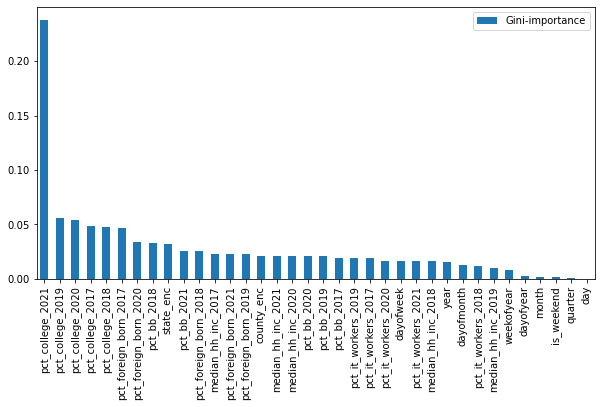

In [125]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, regressor.feature_importances_):
    feats[feature] = importance # add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=90, figsize=(10,5))

# Generating Model Predictions

In [104]:
val_pred = regressor.predict(X_val[features])

score = np.sqrt(mean_squared_error(y_val, val_pred))
r2 = r2_score(y_val, val_pred)
print(f'RMSE: {score} / SMAPE: {SMAPE(y_val, val_pred)}')
print(f'R2: {r2}')

RMSE: 2.4442504712781767 / SMAPE: 8.997014473681771
R2: 0.8236332330409418


In [107]:
predictions = regressor.predict(tst_data[features])
submission['microbusiness_density'] = predictions

# Creates a submission file for Kaggle...
submission.to_csv('submission.csv',index = False)

In [108]:
submission

row_id  microbusiness_density
0       1001_2022-11-01                   3.23
1       1003_2022-11-01                   8.32
2       1005_2022-11-01                   1.26
3       1007_2022-11-01                   1.26
4       1009_2022-11-01                   1.74
...                 ...                    ...
25075  56037_2023-06-01                   3.67
25076  56039_2023-06-01                  25.93
25077  56041_2023-06-01                   3.94
25078  56043_2023-06-01                   4.47
25079  56045_2023-06-01                   2.13

[25080 rows x 2 columns]